# New York University
## Applied Data Science 2016 Final Project
----
## Measuring household income under Redatam in CensusData
----
### *3. Model Evaluation and Selection*
----
**Project Description:** Lorem ipsum

**Members:**
- Felipe Gonzales
- Ilan Reinstein
- Fernando Melchor
- Nicolas Metallo

# LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import simpledbf
%pylab inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib


# HELPER FUNCTIONS

In [2]:
def runModel(dataset, income, varForModel):
    
    '''
    This function takes a data set, runs a model according to specifications,
    and returns the model, printing the summary
    '''
    y = dataset[income].values
    X = dataset.loc[:,varForModel].values
    X = sm.add_constant(X)

    w = dataset.PONDERA
    
    lm = sm.WLS(y, X, weights=1. / w, missing = 'drop', hasconst=True).fit()
    print lm.summary()
    for i in range(1,len(varForModel)+1):
        print 'x%d: %s' % (i,varForModel[i-1])
    #testing within sample
    R_IS=[]
    R_OS=[]
    n=500
    
    for i in range(n):  
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 200)
        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)
        
        lm = linear_model.LinearRegression(fit_intercept=True)
        lm.fit(X_train, y_train, sample_weight = 1. / w[:len(X_train)])
        y_hat_IS = lm.predict(X_train)
        err_IS = y_hat_IS - y_train
        R2_IS = 1 - (np.var(err_IS) / np.var(y_train))
        
        y_hat_OS = lm.predict(X_test)
        err_OS = y_hat_OS - y_test
        R2_OS = 1 - (np.var(err_OS) / np.var(y_test))
        
        R_IS.append(R2_IS)
        R_OS.append(R2_OS)
        
    print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
    print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

# GET DATA

In [3]:
data = pd.read_csv('data/dataFinalParaModelo.csv')
data = data[data.AGLO1 == 32.0]
data.head()

,PONDERA,HomeType,RoomsNumber,FloorMaterial,RoofMaterial,RoofCoat,Water,WaterType,Toilet,ToiletLocation,...,spouseDECCFR,headDECIFR,spouseDECIFR,headMaritalStatus,spouseMaritalStatus,headReading,spouseReading,headPlaceOfBirth,spouseplaceOfBirth,sumPredicted
0,1287,2,2,1.0,NaN,1.0,1.0,1,1,1.0,...,NaN,6.0,NaN,5.0,NaN,1.0,NaN,1.0,NaN,NaN
1,1674,2,2,1.0,1.0,1.0,1.0,1,1,1.0,...,6.0,8.0,8.0,2.0,2.0,1.0,1.0,2.0,2.0,15.469188
2,1522,2,4,1.0,NaN,1.0,1.0,1,1,1.0,...,NaN,5.0,NaN,4.0,NaN,1.0,NaN,3.0,NaN,NaN
3,1320,2,3,1.0,NaN,1.0,1.0,1,1,1.0,...,10.0,10.0,10.0,2.0,2.0,1.0,1.0,1.0,1.0,16.235857
4,1281,2,4,1.0,1.0,1.0,1.0,1,1,1.0,...,9.0,10.0,10.0,2.0,2.0,1.0,1.0,1.0,3.0,8.336136


# DATA EXPLORATION

### Background:

We have found that 'y ~ Total Household Income' works better than other models with a different 'y' (ln of Total Individual Income, Income by Activity, income deciles, etc)

### Correlation Matrix

In [4]:
varForModel = [
 'HomeType',
 'RoomsNumber',
 'FloorMaterial',
 'RoofMaterial',
 'RoofCoat',
 'Water',
 'Toilet',
 'ToiletLocation',
 'ToiletType',
 'Sewer',
 'EmergencyLoc',
 'UsableTotalRooms',
 'SleepingRooms',
 'Kitchen',
 'Sink',
 'Ownership',
 'CookingCombustible',
 'BathroomUse',
 'Working',
 'HouseMembers',
 'Memberless10',
 'Membermore10',
 'TotalFamilyIncome',
 'CookingRec',
 'WaterRec',
 'OwnershipRec',
 'Hacinamiento',
 'schoolAndJob',
 'noJob',
 'job',
 'headAge',
 'spouseAge',
 'headFemale',
 'spouseFemale',
 'headEduc',
 'spouseEduc',
 'headPrimary',
 'spousePrimary',
 'headSecondary',
 'spouseSecondary',
 'headUniversity',
 'spouseUniversity',
 'headJob',
 'spouseJob',
 'headMaritalStatus',
 'spouseMaritalStatus',
 'sumPredicted']

In [5]:
data['hasSpouse'] = np.where(np.isnan(data.spouseJob.values),0,1)
data['spouseJob'] = np.where(np.isnan(data.spouseJob.values),0,data.spouseJob.values)
data['TotalFamilyIncome'].replace(to_replace=[0], value=[1] , inplace=True, axis=None)
data = data[data.TotalFamilyIncomeDecReg != 0]
data['income_log'] = np.log(data.TotalFamilyIncome)
data['FloorMaterial'] = np.where(np.isnan(data.FloorMaterial.values),5,data.FloorMaterial.values)
data['sumPredicted'] = np.where(np.isnan(data.sumPredicted.values),0,data.sumPredicted.values)
data['Sewer'] = np.where(np.isnan(data.Sewer.values),5,data.Sewer.values)
data['ToiletType'] = np.where(np.isnan(data.ToiletType.values),4,data.ToiletType.values)
data['Water'] = np.where(np.isnan(data.Water.values),4,data.Water.values)
data['RoofCoat'] = np.where(np.isnan(data.RoofCoat.values),2,data.RoofCoat.values)
data['income_logPer'] = np.log(data.PerCapInc)
data['haciBool'] = (data.Hacinamiento > 3).astype(int)
data['RoofMaterial'] = np.where(np.isnan(data.RoofMaterial.values),0,data.RoofMaterial.values)
data['ToiletLocation'] = np.where(np.isnan(data.ToiletLocation.values),2,data.ToiletLocation.values)

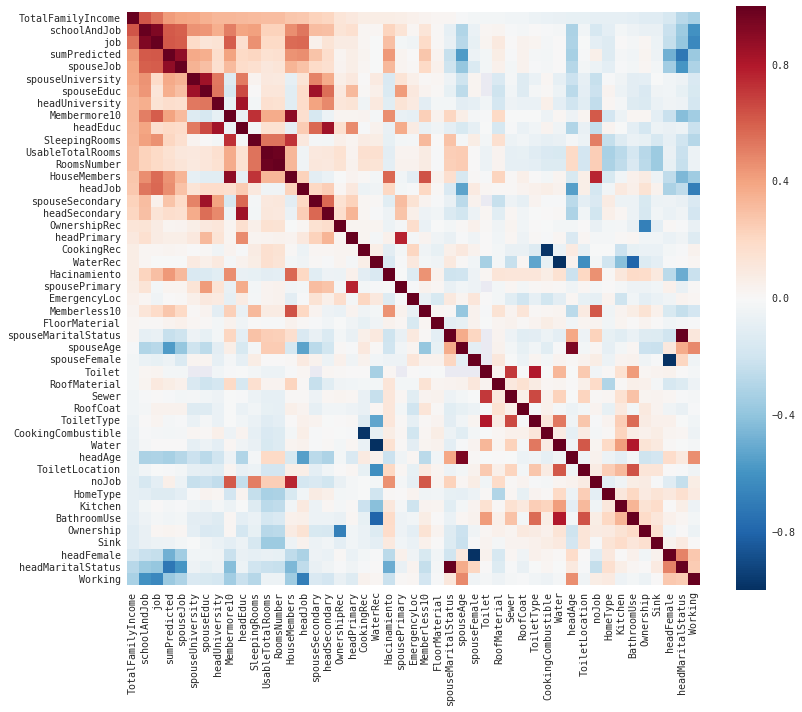

In [6]:
import seaborn as sns
sns.set(context="paper", font="monospace", font_scale=1.25)

corrmat = data.loc[:,list(data.loc[:,varForModel].corr()['TotalFamilyIncome'].sort_values(ascending=False).index)].corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, vmax=.8, square=True)
f.tight_layout()

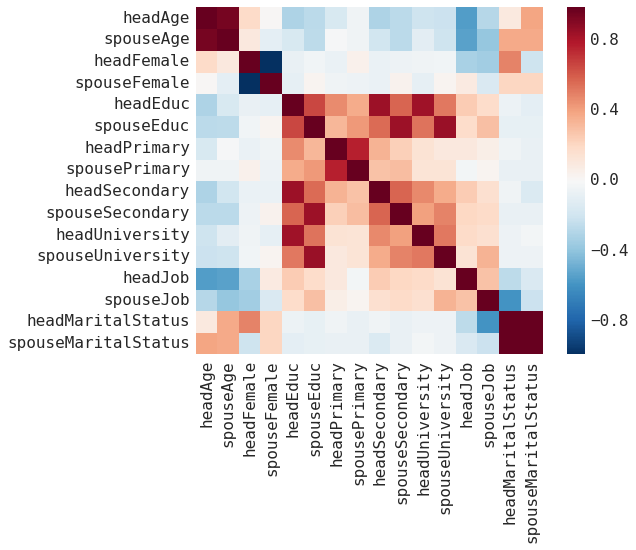

In [7]:
varHomogamy = [
 'headAge',
 'spouseAge',
 'headFemale',
 'spouseFemale',
 'headEduc',
 'spouseEduc',
 'headPrimary',
 'spousePrimary',
 'headSecondary',
 'spouseSecondary',
 'headUniversity',
 'spouseUniversity',
 'headJob',
 'spouseJob',
 'headMaritalStatus',
 'spouseMaritalStatus']

sns.set(context="paper", font="monospace", font_scale=2)

corrmat = data.loc[:,varHomogamy].corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, vmax=.8, square=True)
f.tight_layout()

**Notes:**
    
We found multi-collinearity between variables referencing the spouse and the head of the household. This is we believe a case of homogamy (marriage between individuals who are similar to each other). This is why we chose to ignore them.

In [8]:
varForFeatureSelection = [
 'HomeType',
 'RoomsNumber',
 'FloorMaterial',
 'RoofMaterial',
 'RoofCoat',
 'Water',
 'Toilet',
 'ToiletLocation',
 'ToiletType',
 'Sewer',
 'UsableTotalRooms',
 'SleepingRooms',
 'Kitchen',
 'Sink',
 'Ownership',
 'CookingCombustible',
 'BathroomUse',
 'Working',
 'HouseMembers',
 'Memberless10',
 'Membermore10',
 'CookingRec',
 'WaterRec',
 'OwnershipRec',
 'Hacinamiento',
 'schoolAndJob',
 'noJob',
 'job',
 'headAge',
 'headFemale',
 'headEduc',
 'headPrimary',
 'headSecondary',
 'headUniversity',
 'headJob',
 'sumPredicted']

In [9]:
# !pip install minepy

from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from minepy import MINE
 
Y = data.TotalFamilyIncome
X = np.asarray(data.loc[:,varForFeatureSelection])
    
names = data.loc[:,varForFeatureSelection].columns
 
ranks = {}
 
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))
 
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)
 
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
 
 
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
 
 
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)
 
#stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(map(float, rfe.ranking_), names, order=-1)
 
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)
 
f, pval  = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, names)
 
mine = MINE()
mic_scores = []
for i in range(X.shape[1]):
    mine.compute_score(X[:,i], Y)
    m = mine.mic()
    mic_scores.append(m)
 
ranks["MIC"] = rank_to_dict(mic_scores, names) 
 
 
r = {}
for name in names:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
feat_ranking = pd.DataFrame(ranks)
cols = feat_ranking.columns.tolist()
feat_ranking = feat_ranking.ix[:, cols]
feat_ranking.sort_values(['Corr.'], ascending=False).head(15)

/home/pipe/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Corr.,Lasso,Linear reg,MIC,Mean,RF,RFE,Ridge,Stability
schoolAndJob,1.00,0.07,0.00,1.00,0.60,1.00,0.45,0.28,1.00
job,0.64,0.56,0.03,0.88,0.63,0.01,1.00,1.00,0.95
sumPredicted,0.34,0.02,0.00,0.64,0.29,0.16,0.13,0.07,1.00
Membermore10,0.19,0.02,0.02,0.43,0.24,0.05,0.81,0.14,0.26
headUniversity,0.19,0.03,0.00,0.47,0.27,0.03,0.35,0.12,1.00
Working,0.18,0.06,0.00,0.68,0.26,0.00,0.06,0.23,0.89
headEduc,0.18,0.01,0.00,0.47,0.13,0.04,0.19,0.03,0.12
SleepingRooms,0.17,0.17,0.00,0.49,0.37,0.01,0.68,0.47,0.94
RoomsNumber,0.16,0.01,0.00,0.38,0.18,0.03,0.00,0.01,0.86
UsableTotalRooms,0.16,0.11,0.00,0.38,0.38,0.06,0.90,0.47,0.95


In [10]:
varComparison = list(feat_ranking.sort_values(['Corr.'], ascending=False).head(10).index)
print 'Our first iteration gave us the following table of the top 10 most relevant features: \n'
print varComparison
print '\n'
print 'And this is the correlation Matrix for those features:'
sns.set(context="paper", font="monospace", font_scale=2)

corrmat = data.loc[:,varComparison].corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, vmax=.8, square=True)
f.tight_layout()

NameError: name 'feat_ranking' is not defined

**Conclusion from Feature Selection:**

We found that the most relevant features for predicting income are:
- Eucation
- Job 
- Number of people living in the household.

Accordingly, we chose only the variables that best represented this idea based on their predictive power, model interpretability and possibility of query under **REDATAM**. We also removed features highty correlated between each other to avoid multi-collinearity.

# REGRESSION MODELS

### MODEL TESTING

Our model will be based on education, work and number of people living in the same household. For this, we will test two alternative models each considering separate variables that account for those features.

- ### Model 1a

In [11]:
varForModel = [
    'headEduc',
]

runModel(data, 'TotalFamilyIncome', varForModel)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.098
Model:                            WLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     85.39
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           2.26e-19
Time:                        20:10:17   Log-Likelihood:                -7720.4
No. Observations:                 785   AIC:                         1.544e+04
Df Residuals:                     783   BIC:                         1.545e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        826.4193    570.197      1.449      0.1

- ### Model 1b

In [12]:
varForModel = [
    'headEduc',
    'job', 
]

runModel(data, 'TotalFamilyIncome', varForModel)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.356
Model:                            WLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     216.0
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           2.10e-75
Time:                        20:10:20   Log-Likelihood:                -7588.4
No. Observations:                 785   AIC:                         1.518e+04
Df Residuals:                     782   BIC:                         1.520e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -1315.3112    497.245     -2.645      0.0

- ### Model 1c 

In [13]:
varForModel = [
    'headEduc',
    'job', 
    'SleepingRooms',]

runModel(data, 'TotalFamilyIncome', varForModel)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.367
Model:                            WLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     151.1
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           3.36e-77
Time:                        20:10:22   Log-Likelihood:                -7581.4
No. Observations:                 785   AIC:                         1.517e+04
Df Residuals:                     781   BIC:                         1.519e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -2352.9962    565.552     -4.161      0.0

- ### Model 1d

In [21]:
varForModel = [
    'headEduc',
    'job', 
    'haciBool',
    #'Hacinamiento'
]

runModel(data, 'TotalFamilyIncome', varForModel)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.359
Model:                            WLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     146.1
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           3.94e-75
Time:                        20:12:00   Log-Likelihood:                -7586.2
No. Observations:                 785   AIC:                         1.518e+04
Df Residuals:                     781   BIC:                         1.520e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -1208.5454    498.785     -2.423      0.0

- ### Model 1E (CHOSEN)

In [13]:
varForModel = [
    'headEduc',
    'job', 
    'Hacinamiento'
]

runModel(data, 'TotalFamilyIncome', varForModel)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.359
Model:                            WLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           4.27e-75
Time:                        21:11:37   Log-Likelihood:                -7586.3
No. Observations:                 785   AIC:                         1.518e+04
Df Residuals:                     781   BIC:                         1.520e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -623.5591    599.545     -1.040      0.2

- ### Model 2a

In [11]:
varForModel = [
    'schoolAndJob',
]

runModel(data, 'TotalFamilyIncome', varForModel)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.401
Model:                            WLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     524.0
Date:                Sun, 11 Dec 2016   Prob (F-statistic):           3.48e-89
Time:                        21:11:06   Log-Likelihood:                -7559.9
No. Observations:                 785   AIC:                         1.512e+04
Df Residuals:                     783   BIC:                         1.513e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1890.8406    217.127      8.708      0.0

- ### Model 2b

In [ ]:
varForModel = [
    'SleepingRooms',
    'schoolAndJob',
]

runModel(data, 'TotalFamilyIncome', varForModel)

### MODEL VALIDATION

We are going to test our models against survey data from the Buenos Aires City Government where income is measured by comune (not census block or department) and that it's independent from the survey we used to train our model. 

** GET SURVEY DATA**

In [23]:
dbf = simpledbf.Dbf5('data/BaseEAH2010/EAH10_BU_IND_VERSION2.dbf') # PDF press release is available for download
data10 = dbf.to_dataframe()

data10 = data10.loc[data10.ITFB != 9999999,['ID','COMUNA','FEXP','ITFB']]
data10.head()

,ID,COMUNA,FEXP,ITFB
0,1,1,130.7693,400
1,1,1,130.7693,400
2,1,1,130.7693,400
3,1,1,130.7693,400
4,2,1,47.0046,2000


** DATA CLEANING **

In [24]:
data10.drop_duplicates(inplace = True)
data10.ITFB.replace(to_replace=[0], value=[1] , inplace=True, axis=None)
data10.FEXP = data10.FEXP.astype(int)
data10exp = data10.loc[np.repeat(data10.index.values,data10.FEXP)]
data10exp.ITFB.groupby(by=data10exp.COMUNA).mean()

COMUNA
1     3806.762807
2     6933.011914
3     4301.447851
4     3869.557112
5     5070.870747
6     5603.396225
7     4575.618845
8     2800.941981
9     4667.634219
10    4103.096635
11    5515.926401
12    4720.418917
13    6103.743836
14    6204.832037
15    4843.879949
Name: ITFB, dtype: float64

** GET PREDICTED DATA FROM REDATAM **

The following script transforms the ascii output from REDATAM into a csv file that we can work on later. Our objective is to compare the predicted income from our models related to each comune with the real income for each comune. 

In [25]:
def readRedatamCSV(asciiFile):
    f = open(asciiFile, 'r')
    areas = []
    measures = []
    for line in f:
        columns = line.strip().split()
        # print columns
        if len(columns) > 0:
            if 'RESUMEN' in columns[0] :
                break
            elif columns[0] == 'AREA':
                area = str.split(columns[2],',')[0]
                areas.append(area)
            elif columns[0] == 'Total':
                measure = str.split(columns[2],',')[2]
                measures.append(measure)
    try:        
        data = pd.DataFrame({'area':areas,'measure':measures})
        return data
    except:
        print asciiFile

def R2(dataset,real,predicted):
    fig = plt.figure(figsize=(24,6))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    
    error = dataset[predicted]-dataset[real]
    
    ax1.scatter(dataset[predicted],dataset[real])
    ax1.plot(dataset[real], dataset[real], color = 'red')
    ax1.set_title('Predicted vs Real')
    
    ax2.scatter((dataset[predicted] - dataset[predicted].mean())/dataset[predicted].std(),
                (dataset[real] - dataset[real].mean())/dataset[real].std())
    ax2.plot((dataset[real] - dataset[real].mean())/dataset[real].std(),
             (dataset[real] - dataset[real].mean())/dataset[real].std(), color = 'red')
    ax2.set_title('Standarized Predicted vs Real')

    ax3.scatter(dataset[predicted],(error - error.mean()) / error.std())
    ax3.set_title('Standard Error')
    
    print "R^2 is: ",((dataset[real] - dataset[predicted])**2).sum() / ((dataset[real] - dataset[real].mean())**2).sum()
    print 'Mean Error', error.mean()

** Model 1A **

In [43]:
archivo = 'data/indecOnline/headEduc/comunas.csv' # Model 1A
ingresoXComuna = readRedatamCSV(archivo)
ingresoXComuna.columns = ['area','Predicted_1A']
ingresoXComuna['Real_Income'] = list(data10exp.ITFB.groupby(by=data10exp.COMUNA).mean())
ingresoXComuna = ingresoXComuna.loc[:,['area', 'Real_Income', 'Predicted_1A']]

** Model 1B **

In [44]:
archivo = 'data/indecOnline/headEducYjobs/comuna.csv' # Model 1B
ingresoModelo2 = readRedatamCSV(archivo)
ingresoXComuna = ingresoXComuna.merge(right=ingresoModelo2,on='area')

** Model 1C **

In [45]:
archivo = 'data/indecOnline/headEducuJobsYrooms/comunas.csv' # Model 1A
ingresoModelo3 = readRedatamCSV(archivo)
ingresoXComuna = ingresoXComuna.merge(right=ingresoModelo3,on='area')

** Model 2A **

In [46]:
archivo = 'data/indecOnline/jobSchool/comunas.csv' # Model 2A
ingresoModelo4 = readRedatamCSV(archivo)
ingresoXComuna = ingresoXComuna.merge(right=ingresoModelo4,on='area')

** Model 2B **

In [47]:
archivo = 'data/indecOnline/jobSchoolYrooms/comunas.csv' # Model 2B
ingresoModelo5 = readRedatamCSV(archivo)
ingresoXComuna = ingresoXComuna.merge(right=ingresoModelo5,on='area')

** Model 1D **

In [48]:
archivo = 'data/indecOnline/MODELO1D/comunas.csv' # Model 2B
ingresoModelo6 = readRedatamCSV(archivo)
ingresoXComuna = ingresoXComuna.merge(right=ingresoModelo6,on='area')

** Model 1E **

In [49]:
archivo = 'data/indecOnline/MODELO1E/comunas.csv' # Model 2B
ingresoModelo7 = readRedatamCSV(archivo)
ingresoXComuna = ingresoXComuna.merge(right=ingresoModelo7,on='area')

** DATA CLEANING **

In [50]:
ingresoXComuna.columns = ['Comune','Real_Income','Predicted_1A','Predicted_1B','Predicted_1C',
                          'Predicted_2A','Predicted_2B','Predicted_1D','Predicted_1E']

for i in range(1,9):
    ingresoXComuna.iloc[:,[i]] = ingresoXComuna.iloc[:,[i]].astype(float)

** MODEL EVALUATION RESULTS **

In [51]:
ingresoXComuna

,Comune,Real_Income,Predicted_1A,Predicted_1B,Predicted_1C,Predicted_2A,Predicted_2B,Predicted_1D,Predicted_1E
0,02001,3806.762807,4654.65,5150.35,6218.23,5609.57,5672.81,5076.74,5277.88
1,02002,6933.011914,5389.31,5595.67,6935.92,5994.45,6184.47,5605.28,5866.97
2,02003,4301.447851,4629.02,5180.74,6245.81,5711.07,5772.03,5134.90,5324.32
3,02004,3869.557112,3872.46,4943.48,6098.16,5675.21,5851.23,4871.82,5076.59
4,02005,5070.870747,4695.10,5293.34,6443.76,5962.11,6069.88,5285.51,5490.60
5,02006,5603.396225,4796.01,5377.37,6642.32,6168.19,6338.92,5387.77,5624.67
6,02007,4575.618845,4197.39,5095.96,6355.43,5938.75,6152.72,5056.80,5287.48
7,02008,2800.941981,3348.49,4590.73,5832.88,5400.85,5672.33,4489.44,4707.67
8,02009,4667.634219,3952.79,4955.25,6237.88,5815.04,6063.10,4947.28,5162.20
9,02010,4103.096635,4226.21,5167.14,6453.09,6088.45,6315.20,5174.72,5397.73


# Best Performing Model

R^2 is:  0.849771181733
Mean Error 565.610701552


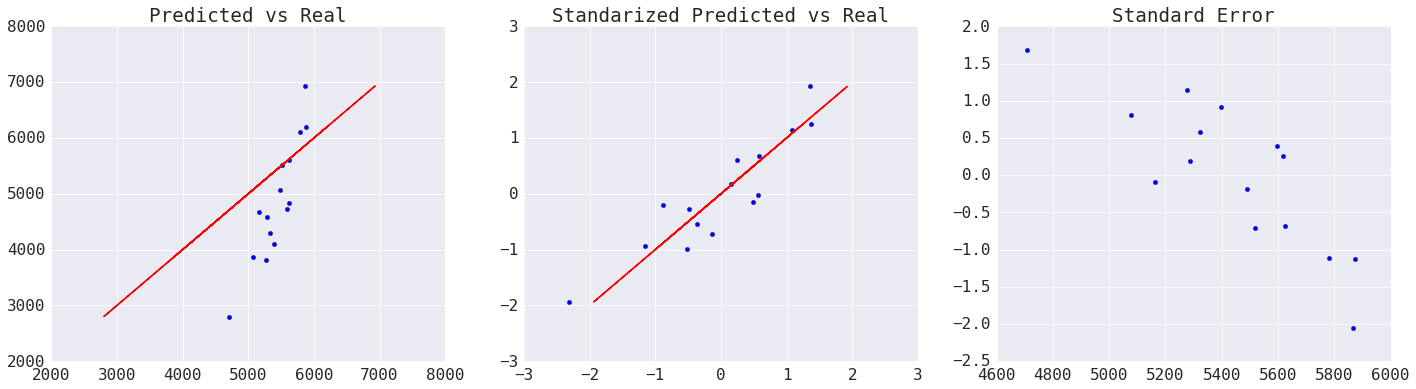

In [56]:
R2 (ingresoXComuna,'Real_Income','Predicted_1E')

# Appendix:

R^2 is:  0.540895198523
Mean Error -385.655965114


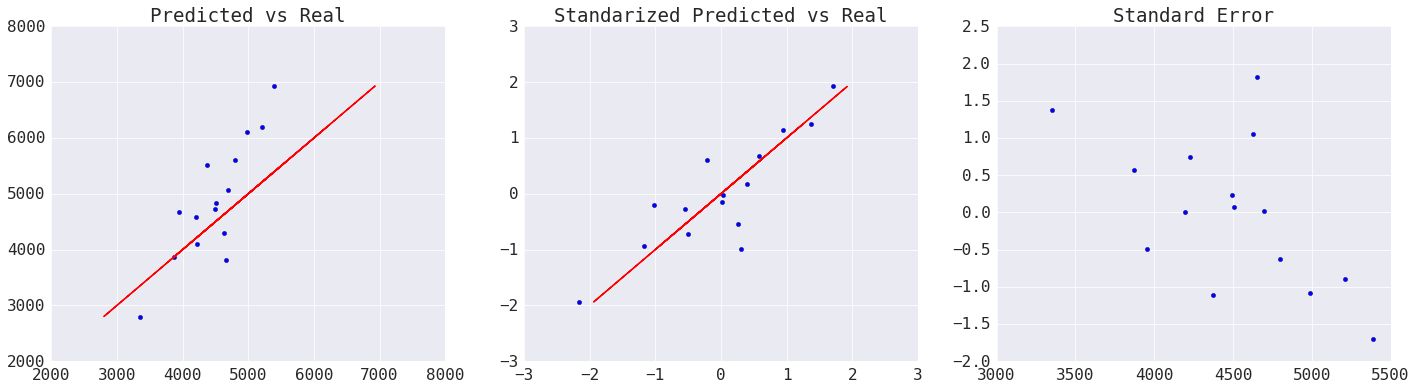

In [246]:
R2 (ingresoXComuna,'Real_Income','Predicted_1A')

R^2 is:  0.735464610823
Mean Error 357.079368219


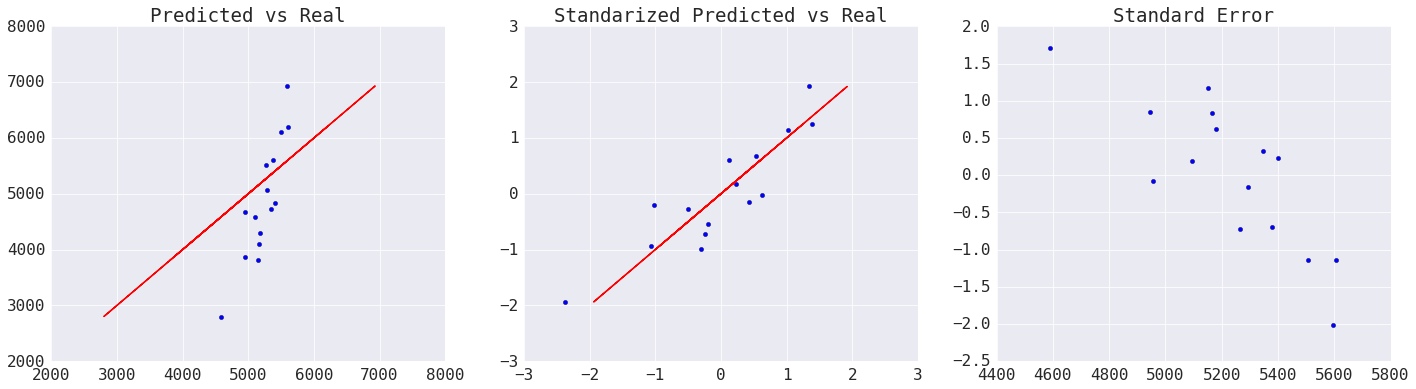

In [247]:
R2 (ingresoXComuna,'Real_Income','Predicted_1B')

R^2 is:  2.92631757058
Mean Error 1597.10536822


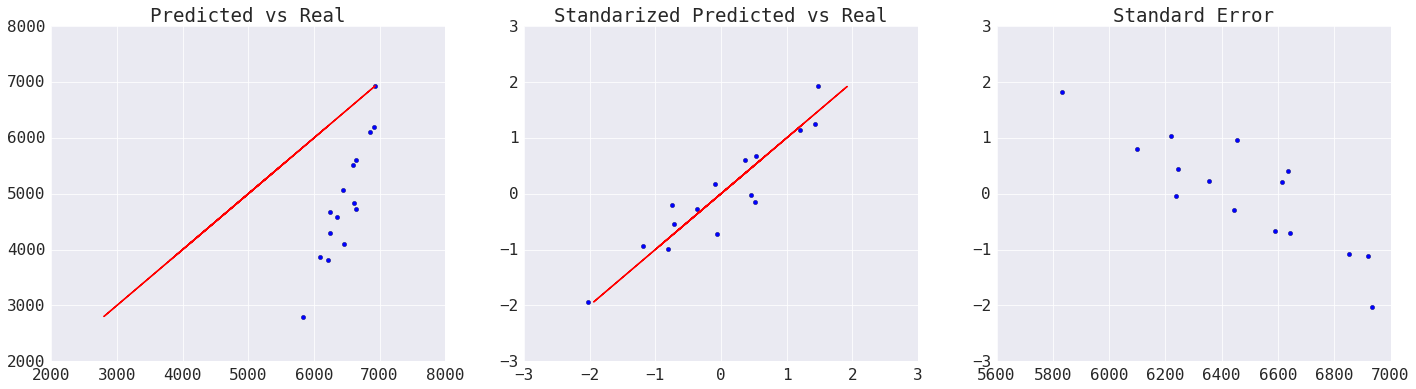

In [248]:
R2 (ingresoXComuna,'Real_Income','Predicted_1C')

R^2 is:  0.682573424962
Mean Error 339.553368219


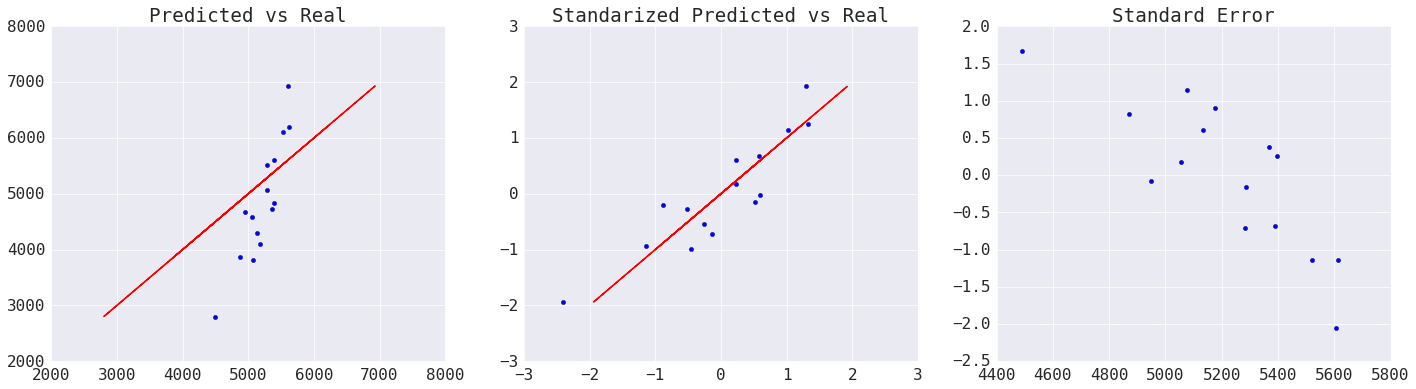

In [53]:
R2 (ingresoXComuna,'Real_Income','Predicted_1D')

R^2 is:  0.849771181733
Mean Error 565.610701552


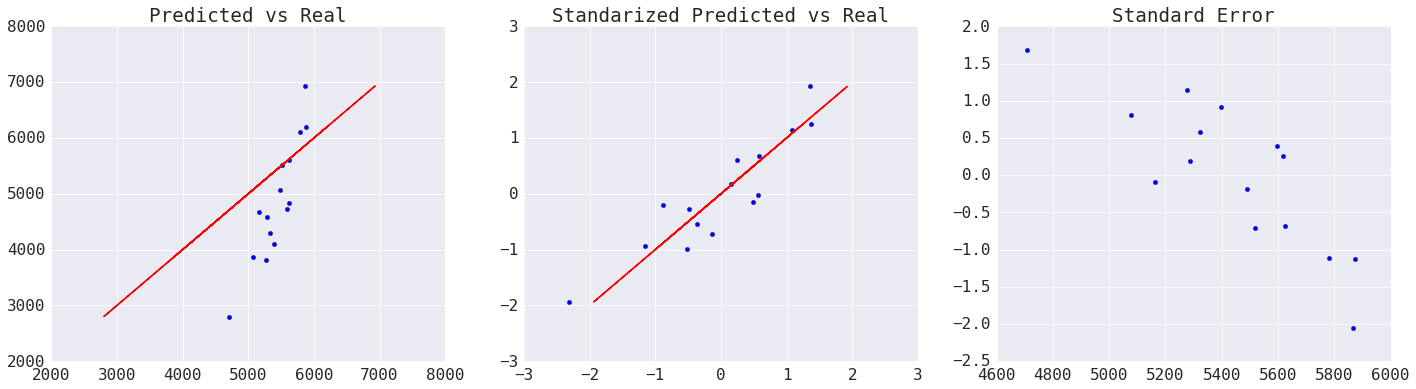

In [54]:
R2 (ingresoXComuna,'Real_Income','Predicted_1E')

R^2 is:  1.81346325165
Mean Error 1090.29670155


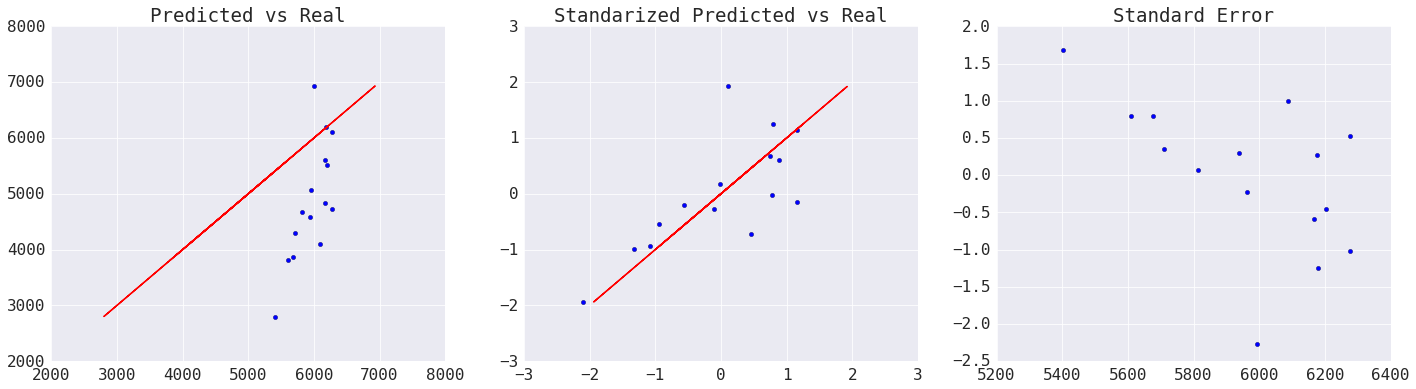

In [249]:
R2 (ingresoXComuna,'Real_Income','Predicted_2A')

R^2 is:  2.22262877079
Mean Error 1272.50136822


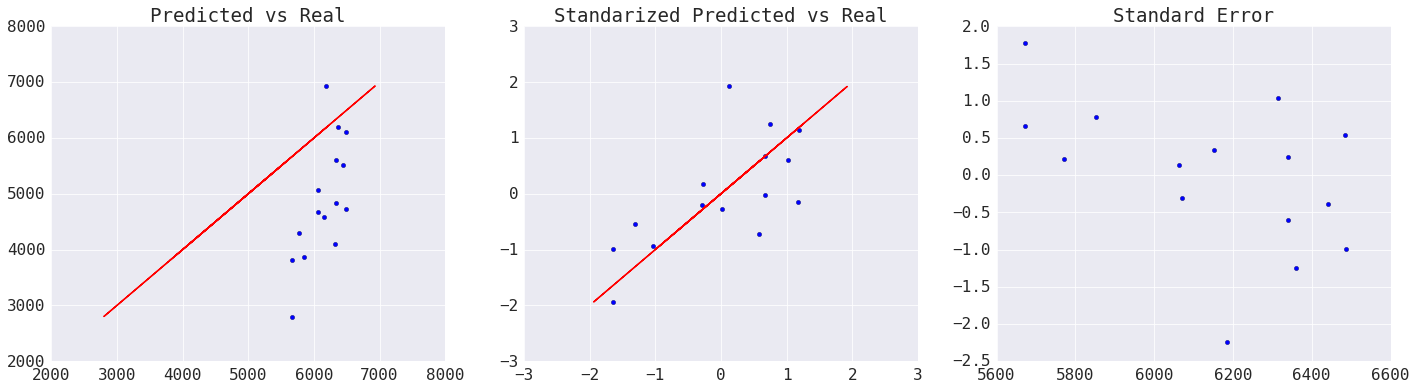

In [250]:
R2 (ingresoXComuna,'Real_Income','Predicted_2B')